# Policing Reservations: White Paper

### This document is intended to walk you through the analysis that was completed in support of this story. The raw code and outcomes are shown below, each including a brief explanation of their relevance to the analysis.

### Setup

In [2]:
# Libraries

library(tidyverse)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [54]:
# Parameters

### File paths
mt_path <- "data/hp256wp2687_mt_statewide_2019_08_13.rds"

mt_path_clean <- "data_cleaning/cleaned_mt_records.csv" # Cleaned data with violations grouped into type

flathead_counties <- c(
    'Flathead County', 
    'Lincoln County', 
    'Lake County', 
    'Mineral County', 
    'Missoula County', 
    'Ravalli County', 
    'Sanders County', 
    'Salish & Kootenai County'
    )

In [55]:
# Load Data

data <-
    mt_path %>%
    read_rds() %>%
    mutate(
        year = year(date)
    ) %>%
    filter(year >= 2010)

#Load cleaned data
data_clean <-
    mt_path_clean %>%
    read_csv() %>%
    mutate(
        year = year(date)
    ) %>%
    filter(year >= 2010)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  time = col_double(),
  year = col_double(),
  lat = col_double(),
  lng = col_double(),
  subject_race = col_character(),
  search_conducted = col_logical(),
  reason_for_stop = col_character(),
  violation_type = col_character(),
  consent_search_conducted = col_logical(),
  raw_search_type = col_character()
)


#### Here you can see an example of what the raw data looks like:

In [10]:
head(data)

raw_row_number,date,time,location,lat,lng,county_name,subject_age,subject_race,subject_sex,⋯,reason_for_stop,vehicle_make,vehicle_model,vehicle_type,vehicle_registration_state,vehicle_year,raw_Race,raw_Ethnicity,raw_SearchType,year
<chr>,<date>,<drtn>,<chr>,<dbl>,<dbl>,<chr>,<int>,<fct>,<fct>,⋯,<chr>,<chr>,<chr>,<chr>,<fct>,<int>,<chr>,<chr>,<chr>,<dbl>
53,2015-08-28,07:24:10,I-90 EB MMM 418,45.59977,-109.0627,Stillwater County,27,white,male,⋯,--- - SPEED OVER LEGAL,FORD (FORD),F35,PICKUP,MT,1996,W,N,NO SEARCH REQUESTED,2015
18438,2010-01-01,00:03:09,WASHINGTON ST AND FIRST AVE,48.77944,-104.5611,Sheridan County,58,white,male,⋯,--- - FAIL TO / IMPROPER SIGNAL,FORD,F25 STYLE,PICKUP,MT,1999,W,N,NO SEARCH REQUESTED,2010
18439,2010-01-01,00:08:56,PINE AT BIG SKY SPUR,45.26102,-111.3094,Gallatin County,37,white,female,⋯,--- - FAIL TO STOP - SIGN OR LIGHT,FORD,FSY Style,CROSSOVER,MT,2005,W,N,NO SEARCH REQUESTED,2010
18440,2010-01-01,00:10:56,I90 MM 299EB,45.75969,-111.1610,Gallatin County,55,white,female,⋯,--- - LIGHT VIOLATIONS,TOYOTA,CAMRY,SEDAN,MT,2001,W,N,NO SEARCH REQUESTED,2010
18441,2010-01-01,00:12:28,100 E FIRST AVE,48.77335,-104.5598,Sheridan County,40,white,male,⋯,--- - DISPLAYING ONLY ONE LICENSE PLATE,FORD,F350 SUPER,PICKUP,MT,2001,W,N,NO SEARCH REQUESTED,2010
18442,2010-01-01,00:15:30,HWY 93 MP 178 SB-35 ZONE,48.87421,-115.0429,Lincoln County,27,white,male,⋯,--- - SPEED OVER LEGAL,ROVER,LR2,CROSSOVER,NA,2008,W,N,NO SEARCH REQUESTED,2010


#### Here you can see all of the columns that were present in the data. These include descriptive details such as time and place of the stop, as well as details about the officer, vehicle, violation, and more.

In [11]:
data %>% colnames()

[1] "raw_row_number"             "date"                      
 [3] "time"                       "location"                  
 [5] "lat"                        "lng"                       
 [7] "county_name"                "subject_age"               
 [9] "subject_race"               "subject_sex"               
[11] "department_name"            "type"                      
[13] "violation"                  "arrest_made"               
[15] "citation_issued"            "warning_issued"            
[17] "outcome"                    "frisk_performed"           
[19] "search_conducted"           "search_basis"              
[21] "reason_for_stop"            "vehicle_make"              
[23] "vehicle_model"              "vehicle_type"              
[25] "vehicle_registration_state" "vehicle_year"              
[27] "raw_Race"                   "raw_Ethnicity"             
[29] "raw_SearchType"             "year"

#### Here you can see how many searches of each type were in the data. Consent searches were of most interest for the analysis due to their utility in examining potential bias. You'll notice that there are a lot of stops didn't result in searches of the vehicle. These are denoted by "NA" below.

In [12]:
data %>% count(search_basis, name = "Count") 

Warning message:
“Factor `search_basis` contains implicit NA, consider using `forcats::fct_explicit_na`”

search_basis,Count
<fct>,<int>
plain view,132
consent,2197
probable cause,43
other,575
NA,803726


#### Upon deciding to analyze the consent search rate, out next question was to understand if certain races were searched at a disproportionate rate. If such a disparity existed, it could indicate bias in officers judgement of who to search. The numbers appears low, but that is because consent searches tend to be fairly rare across every stop. Notably, the rate for Native American drivers is almost 4x as high as it is for White drivers.

In [39]:
data %>%
    group_by(raw_Race) %>%
    filter(raw_Race != "NA", raw_Race != "U") %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(search_basis == "consent", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    ) %>%
    transmute(
        Race = case_when(
            raw_Race == "A" ~ "Asian Drivers",
            raw_Race == "B" ~ "Black Drivers",
            raw_Race == "I" ~ "Native American Drivers",
            raw_Race == "W" ~ "White Drivers"
        ),
        total_stops,
        total_consent_searches = consent_searches,
        consent_search_rate = consent_search_rate %>% round(digits = 2) %>% as.character() %>% paste0("%")
    )

Race,total_stops,total_consent_searches,consent_search_rate
<chr>,<int>,<int>,<chr>
Asian Drivers,6588,31,0.47%
Black Drivers,8655,92,1.06%
Native American Drivers,37882,386,1.02%
White Drivers,750944,1686,0.22%


#### Upon seeing this result, we had many questions. One of them was whether or not this rate was consistent over time. For instance, it could have been due to an anomalous year. We dug in to find out. You'll see that in every year from 2010 - 2016, Native American drivers seemed to be searched more frequently than White drivers.

In [76]:
data %>%
    group_by(year, raw_Race) %>%
    filter(raw_Race %in% c("W", "I"), !is.na(year)) %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(search_basis == "consent", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    ) %>%
    select(-total_stops, -consent_searches) %>%
    spread(key = raw_Race, value = consent_search_rate) %>%
    ungroup() %>%
    transmute(
        year,
        'How Much More Often Were Native Drivers Searched' = round(I/W, digits = 1) %>% as.character() %>% paste0("x"),
        native_american_search_rate = I %>% round(digits = 2) %>% as.character() %>% paste0("%"),
        white_search_rate = W %>% round(digits = 2) %>% as.character() %>% paste0("%")
    )

year,How Much More Often Were Native Drivers Searched,native_american_search_rate,white_search_rate
<dbl>,<chr>,<chr>,<chr>
2010,1.2x,0.21%,0.17%
2011,2.8x,0.41%,0.15%
2012,2.3x,0.34%,0.15%
2013,3.2x,0.6%,0.19%
2014,6.2x,1.87%,0.3%
2015,4.9x,1.59%,0.32%
2016,6.1x,1.94%,0.32%


#### Realizing that this disparity is consistent over time, we turned out attention to geographic differences. Below, we analyze the search rate disparity in and around the Flathead Reservation. We were curious to know if biased practices seemed to increase when policing in and around the reservation. We found that they did and the Native drivers were searched roughly 11x as often as White drivers in this area.

In [75]:
data %>%
    group_by(raw_Race) %>%
    filter(raw_Race %in% c("W", "I"), county_name %in% flathead_counties) %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(search_basis == "consent", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    ) %>%
    select(-total_stops, -consent_searches) %>%
    spread(key = raw_Race, value = consent_search_rate) %>%
    ungroup() %>%
    transmute(
        'How Much More Often Were Native Drivers Searched' = round(I/W, digits = 1) %>% as.character() %>% paste0("x"),
        native_american_search_rate = I %>% round(digits = 2) %>% as.character() %>% paste0("%"),
        white_search_rate = W %>% round(digits = 2) %>% as.character() %>% paste0("%")
    )

How Much More Often Were Native Drivers Searched,native_american_search_rate,white_search_rate
<chr>,<chr>,<chr>
11.5x,3.02%,0.26%


#### Next we wanted to chose to explore nuances in the stop data. What was it that was leading officers to search Native American drivers more? Perhaps the nature of the stop and the related violation had something to do with it. Below we analyze that data and find that each race seems to be stopped for very similar things.

In [70]:
data_clean %>%
    filter(subject_race %in% c("white", "indigenous"), !is.na(violation_type)) %>%
    group_by(subject_race) %>%
    count(violation_type) %>%
    arrange(desc(subject_race), desc(n)) %>%
    top_n(4, wt = n) %>%
    ungroup() %>%
    transmute(
        Race = case_when(
            subject_race == "indigenous" ~ "Native American Drivers",
            subject_race == "white" ~ "White Drivers"
        ),
        top_violations = violation_type,
        total_stops = n
    )

Race,top_violations,total_stops
<chr>,<chr>,<int>
White Drivers,motor vehicle hazardous,585626
White Drivers,license/registration/insurance,34039
White Drivers,commercial,16343
White Drivers,equipment,15235
Native American Drivers,motor vehicle hazardous,27771
Native American Drivers,license/registration/insurance,2321
Native American Drivers,equipment,2001
Native American Drivers,other,609


#### When looking at stops that incluided just these top violations, was there still a disparity in search rates? The answer is yes, indicating that though Native American drivers are being stopped for similar violations, they are still being searched at roughly 5x the rate of white drivers. Thus, the disparity doesn't seem to be related to differences in each demographic's violations.

In [74]:
data_clean %>%
    group_by(subject_race) %>%
    filter(subject_race %in% c("white", "indigenous"), violation_type %in% c("motor vehicle hazardous", "license/registration/insurance", "equipment")) %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(raw_search_type == "CONSENT SEARCH CONDUCTED", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    ) %>%
    select(-total_stops, -consent_searches) %>%
    spread(key = subject_race, value = consent_search_rate) %>%
    ungroup() %>%
    transmute(
        'How Much More Often Were Native Drivers Searched' = round(indigenous/white, digits = 1) %>% as.character() %>% paste0("x"),
        native_american_search_rate = indigenous %>% round(digits = 2) %>% as.character() %>% paste0("%"),
        white_search_rate = white %>% round(digits = 2) %>% as.character() %>% paste0("%")
    )

How Much More Often Were Native Drivers Stopped,native_american_search_rate,white_search_rate
<chr>,<chr>,<chr>
5.1x,0.98%,0.19%


In [73]:
data_clean %>% count(raw_search_type)

raw_search_type,n
<chr>,<int>
CONSENT SEARCH CONDUCTED,2197
INVENTORY,8
NO SEARCH / CONSENT DENIED,374
NO SEARCH REQUESTED,803340
PLAIN VIEW,132
PROBABLE CAUSE,43
PROBATION/PAROLE OFFICER CONSENT,57
SEARCH INCIDENT TO ARREST,136
SEARCH WARRANT,374


### Review

#### 1) Native American & White Consent Search Rate for 2010-2016

SENTENCE: "Between 2010 and 2016, officers searched 10 of every 1,000 Native American drivers they stopped — more than four times the rate at which they searched white drivers."

CHECKING:
* NA consent search rate
* White consent search rate

In [21]:
one_data <- 
    data %>%
    group_by(raw_Race) %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(search_basis == "consent", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    )

one_data

raw_Race,total_stops,consent_searches,consent_search_rate
NA,8,0,0.00000000
A,6700,33,0.49253731
B,8806,93,1.05609811
I,38795,388,1.00012888
U,2634,2,0.07593014
W,768175,1724,0.22442803


In [22]:
one_na_csearch_rate <-
    one_data %>%
    filter(raw_Race == "I") %>%
    pull(consent_search_rate) %>%
    round(digits = 4)

one_w_csearch_rate <-
    one_data %>%
    filter(raw_Race == "W") %>%
    pull(consent_search_rate) %>%
    round(digits = 4)

#### Findings

In [23]:
paste0("Native American Consent Search Rate: ", one_na_csearch_rate, "%")
paste0("White Consent Search Rate: ", one_w_csearch_rate, "%")

paste0(
    "Native American drivers are subjected to consent searches ",
    round(one_na_csearch_rate/one_w_csearch_rate, digits = 1), 
    "x more often than White drivers."
)

[1] "Native American Consent Search Rate: 1.0001%"

[1] "White Consent Search Rate: 0.2244%"

[1] "Native American drivers are subjected to consent searches 4.5x more often than White drivers."

#### 2) Change in Native American & White Consent Search Rate from 2010 to 2016

SENTENCE: "While search rates for Native American and white drivers were closer together in 2010, by 2016, the two search rates had diverged sharply: The search rate of Native American drivers across the state was six times the search rate of white drivers."

CHECKING:
* NA and White consent search rate in 2010
* NA and White consent search rate in 2016

In [24]:
data %>%
    group_by(year, raw_Race) %>%
    filter(raw_Race %in% c("W", "I"), !is.na(year)) %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(search_basis == "consent", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    ) 

two_data <-
    data %>%
    group_by(year, raw_Race) %>%
    filter(raw_Race %in% c("W", "I"), !is.na(year)) %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(search_basis == "consent", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    ) %>%
    select(-total_stops, -consent_searches) %>%
    spread(key = raw_Race, value = consent_search_rate) %>%
    mutate(na_to_white_search_proportion = round(I/W, digits = 1))

two_data

year,raw_Race,total_stops,consent_searches,consent_search_rate
2009,I,913,2,0.2190581
2009,W,17220,38,0.2206736
2010,I,5702,12,0.2104525
2010,W,116418,203,0.1743717
2011,I,5113,21,0.4107178
2011,W,115694,172,0.1486680
2012,I,5035,17,0.3376365
2012,W,110193,162,0.1470148
2013,I,4812,29,0.6026600
2013,W,107109,200,0.1867257


year,I,W,na_to_white_search_proportion
2009,0.2190581,0.2206736,1.0
2010,0.2104525,0.1743717,1.2
2011,0.4107178,0.1486680,2.8
2012,0.3376365,0.1470148,2.3
2013,0.6026600,0.1867257,3.2
2014,1.8712575,0.3032028,6.2
2015,1.5897048,0.3214373,4.9
2016,1.9351167,0.3196767,6.1


#### Findings

In [25]:
for (y in two_data$year) {
    
    two_na_csearch_rate <- two_data %>% filter(year == y) %>% pull(na_to_white_search_proportion)
    
    paste0("In ", y, " Native Americans were searched at ", two_na_csearch_rate, "x the rate that white drivers were searched at.") %>% print()
    
}

[1] "In 2009 Native Americans were searched at 1x the rate that white drivers were searched at."
[1] "In 2010 Native Americans were searched at 1.2x the rate that white drivers were searched at."
[1] "In 2011 Native Americans were searched at 2.8x the rate that white drivers were searched at."
[1] "In 2012 Native Americans were searched at 2.3x the rate that white drivers were searched at."
[1] "In 2013 Native Americans were searched at 3.2x the rate that white drivers were searched at."
[1] "In 2014 Native Americans were searched at 6.2x the rate that white drivers were searched at."
[1] "In 2015 Native Americans were searched at 4.9x the rate that white drivers were searched at."
[1] "In 2016 Native Americans were searched at 6.1x the rate that white drivers were searched at."


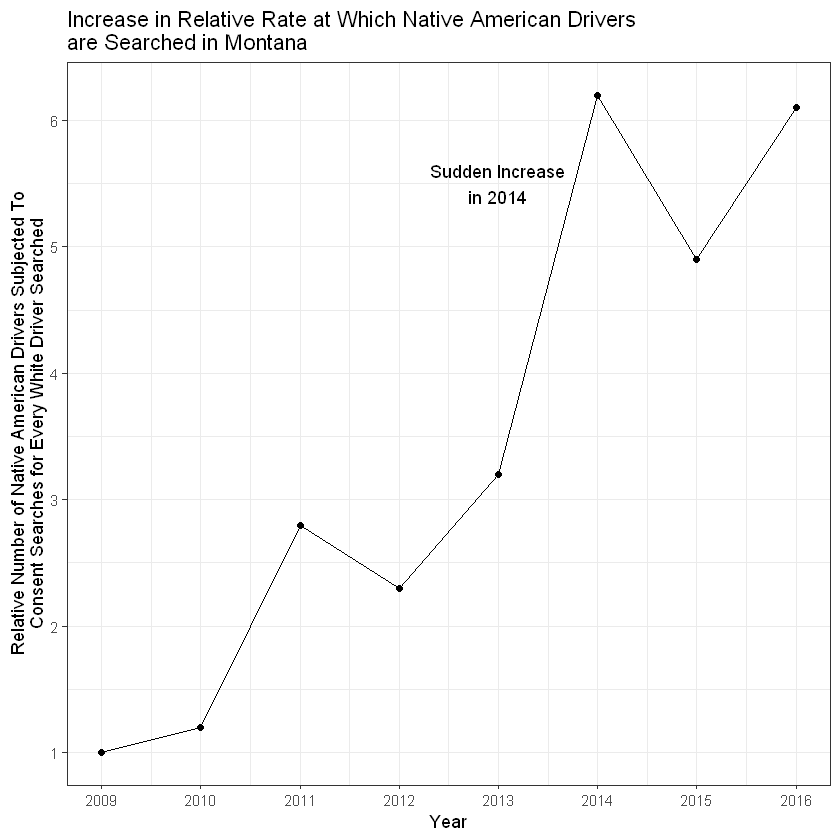

In [26]:
two_data %>%
    ggplot(aes(x = year, y = na_to_white_search_proportion)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    scale_x_continuous(
    labels = two_data$year %>% as.character(),
    breaks = two_data$year
    ) +
    annotate(geom = "text", x = 2013, y = 5.5, label = "Sudden Increase\nin 2014") +
    scale_y_continuous(
        labels = c(1:6) %>% as.character(),
        breaks = c(1:6)
    ) +
    labs(
        title = "Increase in Relative Rate at Which Native American Drivers\nare Searched in Montana",
        x = "Year",
        y = "Relative Number of Native American Drivers Subjected To\nConsent Searches for Every White Driver Searched"
    )

#### 3) Native American and White Consent Search Rate On and Near Flathead Indian Reservation

SENTENCE: "In the highway patrol districts covering the Flathead Indian Reservation, a 1,900-square-mile expanse near the western border of the state, officers searched 30 of every 1,000 Native American drivers they stopped but only three of every 1,000 white drivers."

CHECKING:
* NA and White consent search rate in counties in/surrounding Flathead Indian Reservation

In [27]:
three_data <-
    data %>%
    group_by(raw_Race) %>%
    filter(raw_Race %in% c("W", "I"), county_name %in% flathead_counties) %>%
    summarise(
        total_stops = n(),
        consent_searches = sum(search_basis == "consent", na.rm = TRUE),
        consent_search_rate = (consent_searches/total_stops) * 100
    )

three_data

raw_Race,total_stops,consent_searches,consent_search_rate
I,7143,209,2.9259415
W,214210,553,0.2581579


In [28]:
three_na_csearch_rate <-
    three_data %>%
    filter(raw_Race == "I") %>%
    pull(consent_search_rate) %>%
    round(digits = 4)

three_w_csearch_rate <-
    three_data %>%
    filter(raw_Race == "W") %>%
    pull(consent_search_rate) %>%
    round(digits = 4)

#### Findings

In [29]:
paste0("Native American Consent Search Rate Around Flathead: ", three_na_csearch_rate, "%")
paste0("White Consent Search Rate Around Flathead: ", three_w_csearch_rate, "%")

paste0(
    "Native American drivers are subjected to consent searches ",
    round(three_na_csearch_rate/three_w_csearch_rate, digits = 1), 
    "x more often than White drivers around Flathead Indian Reservation."
)

[1] "Native American Consent Search Rate Around Flathead: 2.9259%"

[1] "White Consent Search Rate Around Flathead: 0.2582%"

[1] "Native American drivers are subjected to consent searches 11.3x more often than White drivers around Flathead Indian Reservation."

### 4) Proportion of Data Made up by Native Americans

SENTENCE: "Native American drivers made up less than 5% of Montana Highway Patrol traffic stops but more than 17% of consent searches in the state."

CHECKING:
* Proportion of Native Americans in the stops data
* Proportion of Native Americans in the consent search data

In [49]:
#Proportion of each race in the stops data
data <- filter(data, year(date) > 2009)
data %>% 
  count(raw_Race) %>% 
  mutate(prop_stops = n / sum(n))

raw_Race,n,prop_stops
NA,8,9.917278e-06
A,6588,8.166878e-03
B,8655,1.072925e-02
I,37882,4.696079e-02
U,2596,3.218157e-03
W,750944,9.309150e-01


In [36]:
#Proportion of each race after filtering to just consent searches

consent_searches_data <- data %>% filter(search_basis == 'consent')
consent_searches_data %>% 
  count(raw_Race) %>% 
  mutate(prop_consent = n / sum(n))

raw_Race,n,prop_consent
A,31,0.0141101502
B,92,0.0418752845
I,386,0.1756941284
U,2,0.0009103323
W,1686,0.7674101047


### 5) Arrest Rates

SENTENCE: "An analysis of the 500 arrests made following consent searches found a higher arrest rate for Native American drivers than white drivers. Three of every ten Native American drivers subject to a consent search were arrested, compared to only two of every ten white drivers subject to a consent search."

CHECKING:
* Arrest Rate for Native American drivers who were consent searched
* Arrest Rate for white drivers who were consent searched

In [33]:
consent_searches_data %>% 
  group_by(raw_Race) %>% 
  summarize(
    arrest_rate = mean(arrest_made, na.rm = T),
  )

raw_Race,arrest_rate
A,0.06060606
B,0.12903226
I,0.31958763
U,0.50000000
W,0.21461717


### 6) Consent Search Rate Around Flathead

SENTENCE: "Two patrol districts — District 1 and District 6 — bisect the Flathead Indian Reservation. Between 2010 and 2016, the search rate for Native American drivers in those districts was three times higher than the statewide search rate for Native American drivers. Meanwhile, officers searched white drivers travelling in the same territory at a rate consistent with the statewide trend."

CHECKING:
* Statewide consent search rate for Native American drivers
* Consent search rate for Native American drivers around Flathead
* Statewide consent search rate for white drivers
* Consent search rate for white drivvers around Flathead

In [50]:
#Statewide consent search rate for all races

data %>%
group_by(raw_Race) %>%
summarize(
    total_stops = n(),
    consent_searches = sum(search_basis == "consent", na.rm = T),
    consent_search_rate = (consent_searches/total_stops)
)

raw_Race,total_stops,consent_searches,consent_search_rate
NA,8,0,0.000000000
A,6588,31,0.004705525
B,8655,92,0.010629694
I,37882,386,0.010189536
U,2596,2,0.000770416
W,750944,1686,0.002245174


In [51]:
#Flathead consent search rate for all races

flat_head_data <- data %>% filter(county_name %in% flathead_counties)

flat_head_data %>%
group_by(raw_Race) %>%
summarize(
    total_stops = n(),
    consent_searches = sum(search_basis == "consent", na.rm = T),
    consent_search_rate = (consent_searches/total_stops)
)

raw_Race,total_stops,consent_searches,consent_search_rate
NA,2,0,0.000000000
A,1347,7,0.005196733
B,1361,21,0.015429831
I,6883,208,0.030219381
U,537,2,0.003724395
W,208580,549,0.002632084


### 7) Number of Consent Searches of Native Americans in 2013 and 2014 near Flathead

SENTENCE: "Officers searched Native Americans 11 times in 2013 and 72 times the following year, outpacing a smaller increase in searches among white drivers."

CHECKING:
* Number of Native American consent searches in 2013 near Flathead
* Number of Native American consent searches in 2014 near Flathead
* Number of white consent searches in 2013 near Flathead
* Number of white consent searches in 2014 near Flathead

In [55]:
#Number of consent searches around Flathead in 2013

data_2013 <- data %>% filter(year(date) == 2013, search_basis == "consent", county_name %in% flathead_counties)

data_2013 %>%
count(raw_Race)

raw_Race,n
B,2
I,11
W,51


In [56]:
#Number of consent searches around Flathead in 2014

data_2014 <- data %>% filter(year(date) == 2014, search_basis == "consent", county_name %in% flathead_counties)

data_2014 %>%
count(raw_Race)

raw_Race,n
A,3
B,6
I,72
U,1
W,140
